In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
def compute_motion_features(df, alpha_deg=0, theta_deg=30, R=40, L=125):
    # 角度转为弧度
    alpha_rad = np.radians(alpha_deg)
    theta_rad = np.radians(theta_deg)

    # 角速度向量：三列 ω1, ω2, ω3，转置为 shape(3, N)
    angular_vel = df[['ω1', 'ω2', 'ω3']].to_numpy().T

    # 电流向量：三列 I1, I2, I3，转置为 shape(3, N)
    current_vals = df[['I1', 'I2', 'I3']].to_numpy().T

    # 构建速度转换矩阵（乘以 R）
    velocity_transform = np.array([
        [-2/3 * np.cos(alpha_rad - theta_rad),  2/3 * np.sin(alpha_rad),        2/3 * np.cos(alpha_rad + theta_rad)],
        [-2/3 * np.sin(alpha_rad - theta_rad), -2/3 * np.cos(alpha_rad),        2/3 * np.sin(alpha_rad + theta_rad)],
        [1/(3 * L),                             1/(3 * L),                       1/(3 * L)]
    ]) * R

    # 构建电流变换矩阵
    current_transform = np.array([
        [-2/3 * np.cos(alpha_rad - theta_rad),  2/3 * np.sin(alpha_rad),        2/3 * np.cos(alpha_rad + theta_rad)],
        [-2/3 * np.sin(alpha_rad - theta_rad), -2/3 * np.cos(alpha_rad),        2/3 * np.sin(alpha_rad + theta_rad)],
        [1/3,                                   1/3,                             1/3]
    ])

    # 位移速度变换（Vx, Vy, Ω）
    motion_vector = velocity_transform @ angular_vel
    df['Vx'] = motion_vector[0]
    df['Vy'] = motion_vector[1]
    df['Ω']  = motion_vector[2]

    # 电流合成分量（Ix, Iy, Iφ）
    transformed_current = current_transform @ current_vals
    df['Ix'] = transformed_current[0]
    df['Iy'] = transformed_current[1]
    df['Iφ'] = transformed_current[2]

    # 总电流幅值 IΣ
    df['IΣ'] = np.linalg.norm(transformed_current, axis=0)

    return df


In [26]:
# 导入原始数据集
raw_data = pd.read_excel("Data_Set_(A+B).xlsx")

# 计算运动特征（调用已定义函数）
data = compute_motion_features(raw_data)

# 创建二分类标签列：是否属于类别5
data['target'] = (data['Type'] == 5).astype(int)

# 指定模型使用的特征列
selected_features = [
    'N1', 'N2', 'N3',       # 电机转速
    'ω1', 'ω2', 'ω3',       # 角速度
    'I1', 'I2', 'I3',       # 电流
    'gx', 'gy', 'gz',       # 陀螺仪
    'ax', 'ay', 'az',       # 加速度
    'Vx', 'Vy', 'Ω',        # 运动速度特征
    'Ix', 'Iy', 'Iφ', 'IΣ'  # 运动电流合成特征
]

# 构建特征矩阵和目标向量
X = data[selected_features]  # 特征变量
y = data['target']           # 目标变量（二分类标签）


Config: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'relu', 'solver': 'adam'}
CV F1 Score: 0.0695, Std: 0.0000

Config: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'adam'}
CV F1 Score: 0.7020, Std: 0.0049

Config: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'sgd'}
CV F1 Score: 0.7020, Std: 0.0049

Config: {'max_iter': 500, 'hidden_layer_sizes': (50, 30), 'activation': 'tanh', 'solver': 'adam'}
CV F1 Score: 0.7261, Std: 0.0339

Config: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'adam'}
CV F1 Score: 0.7020, Std: 0.0049

Config: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
CV F1 Score: 0.6962, Std: 0.0095

Config: {'max_iter': 1000, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
CV F1 Score: 0.6962, Std: 0.0095

Config: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'logistic', 'so

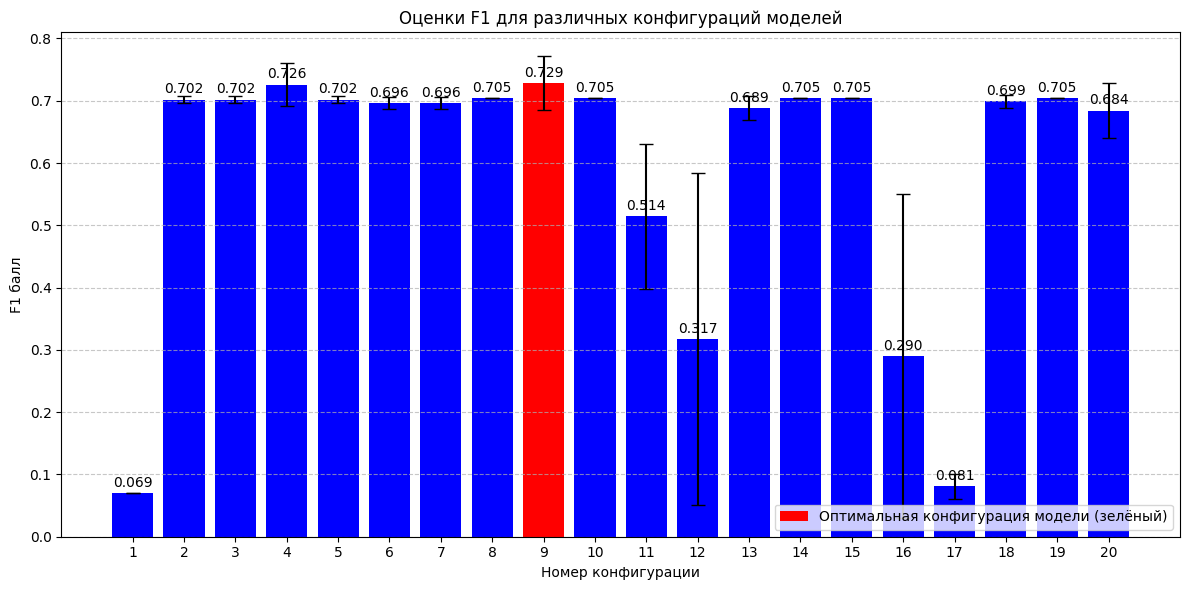

Оптимальная конфигурация модели:
Config: {'max_iter': 500, 'hidden_layer_sizes': (100, 50, 25), 'activation': 'tanh', 'solver': 'adam'}
F1 Score: 0.7286


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

best_config = None
best_score = -1
all_results = []

# 模型配置列表
configs = [
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50, 30), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (100, 50, 25), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (100,), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "relu", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50,), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (50,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "relu", "solver": "adam"}
]

# 循环遍历每种配置，执行4折交叉验证
for config in configs:
    model = MLPClassifier(random_state=42, **config)
    scores = cross_val_score(model, X, y, cv=4, scoring='f1_weighted')
    mean_score = scores.mean()
    std_score = scores.std()
    
    all_results.append((config, mean_score, std_score))
    
    print(f"Config: {config}")
    print(f"CV F1 Score: {mean_score:.4f}, Std: {std_score:.4f}\n")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = config

# 提取 F1 分数及标签
f1_scores = [score for (_, score, _) in all_results]
std_scores = [std for (_, _, std) in all_results]
config_labels = [f"{i+1}" for i in range(len(all_results))]

# 找出最佳配置索引
best_index = np.argmax(f1_scores)

# 设置柱状图颜色：默认红色，最佳模型绿色
colors = ['blue'] * len(f1_scores)
colors[best_index] = 'red'

# 绘制图形
plt.figure(figsize=(12, 6))
bars = plt.bar(config_labels, f1_scores, color=colors, yerr=std_scores, capsize=5)

# 添加每根柱子的数值标签
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom')

# 设置图表标题和轴标签（俄语）
plt.title("Оценки F1 для различных конфигураций моделей")
plt.xlabel("Номер конфигурации")
plt.ylabel("F1 балл")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加图例说明
plt.legend(handles=[bars[best_index]], labels=['Оптимальная конфигурация модели (зелёный)'], loc='lower right')

plt.tight_layout()
plt.show()

# 输出最佳模型配置和得分
print("Оптимальная конфигурация модели:")
print(f"Config: {best_config}")
print(f"F1 Score: {best_score:.4f}")


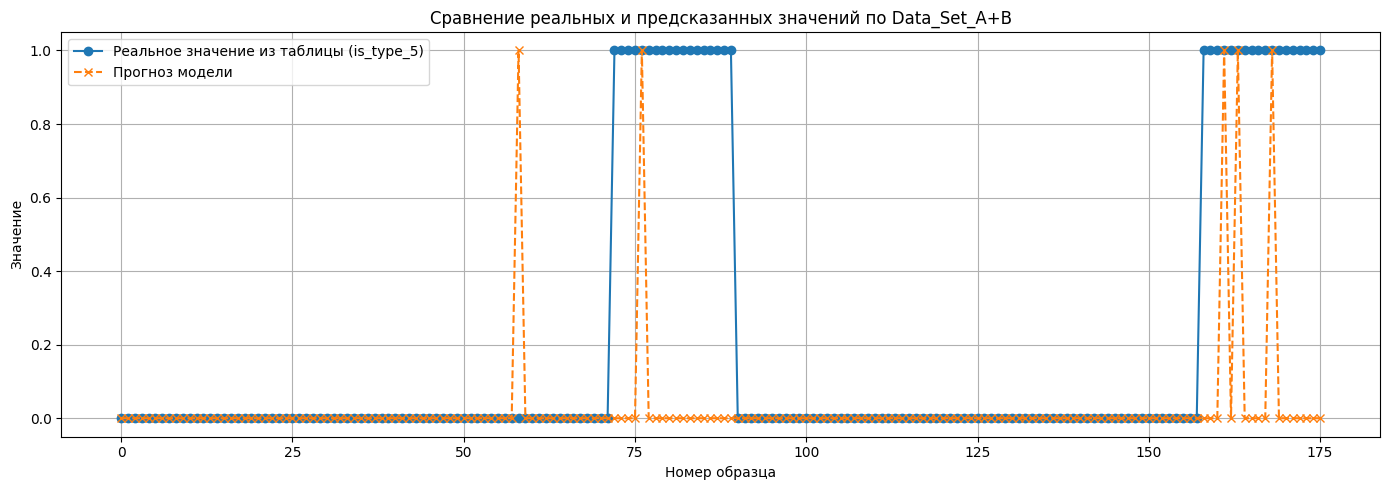

In [28]:
# 使用最佳模型配置构建 MLP 分类器
final_model = MLPClassifier(hidden_layer_sizes=(100, 50, 25),
                            activation='tanh',
                            solver='adam',
                            max_iter=500,
                            random_state=42)

# 模型训练
final_model.fit(X, y)

# 模型预测
y_pred = final_model.predict(X)
N = len(y)

# 可视化：真实值 vs 预测值
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y[:N], label='Реальное значение из таблицы (is_type_5)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Прогноз модели', marker='x', linestyle='--')

# 图形设置（俄语说明）
plt.title('Сравнение реальных и предсказанных значений по Data_Set_A+B')
plt.xlabel('Номер образца')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# 导入经过排序的数据集
sorted_data = pd.read_excel("Data Set_(A+B) (sort).xlsx")

# 特征计算（调用前面定义的 compute_motion_features 函数）
sorted_data = compute_motion_features(sorted_data)

# 创建二分类目标变量：是否为类别5（type=5）
sorted_data['target'] = (sorted_data['Type'] == 5).astype(int)

# 选取模型输入特征
sorted_features = [
    'N1', 'N2', 'N3',        # 电机转速
    'ω1', 'ω2', 'ω3',        # 角速度
    'I1', 'I2', 'I3',        # 三相电流
    'gx', 'gy', 'gz',        # 陀螺仪
    'ax', 'ay', 'az',        # 加速度计
    'Vx', 'Vy', 'Ω',         # 平面运动特征
    'Ix', 'Iy', 'Iφ', 'IΣ'   # 综合电流特征
]

# 构建特征矩阵和目标向量
X = sorted_data[sorted_features]
y = sorted_data['target']


Config: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'relu', 'solver': 'adam'}
CV F1 Score: 0.0695, Std: 0.0000

Config: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'adam'}
CV F1 Score: 0.7020, Std: 0.0049

Config: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'sgd'}
CV F1 Score: 0.7020, Std: 0.0049

Config: {'max_iter': 500, 'hidden_layer_sizes': (50, 30), 'activation': 'tanh', 'solver': 'adam'}
CV F1 Score: 0.6641, Std: 0.0513

Config: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'adam'}
CV F1 Score: 0.6991, Std: 0.0100

Config: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
CV F1 Score: 0.6991, Std: 0.0100

Config: {'max_iter': 1000, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
CV F1 Score: 0.6991, Std: 0.0100

Config: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'logistic', 'so

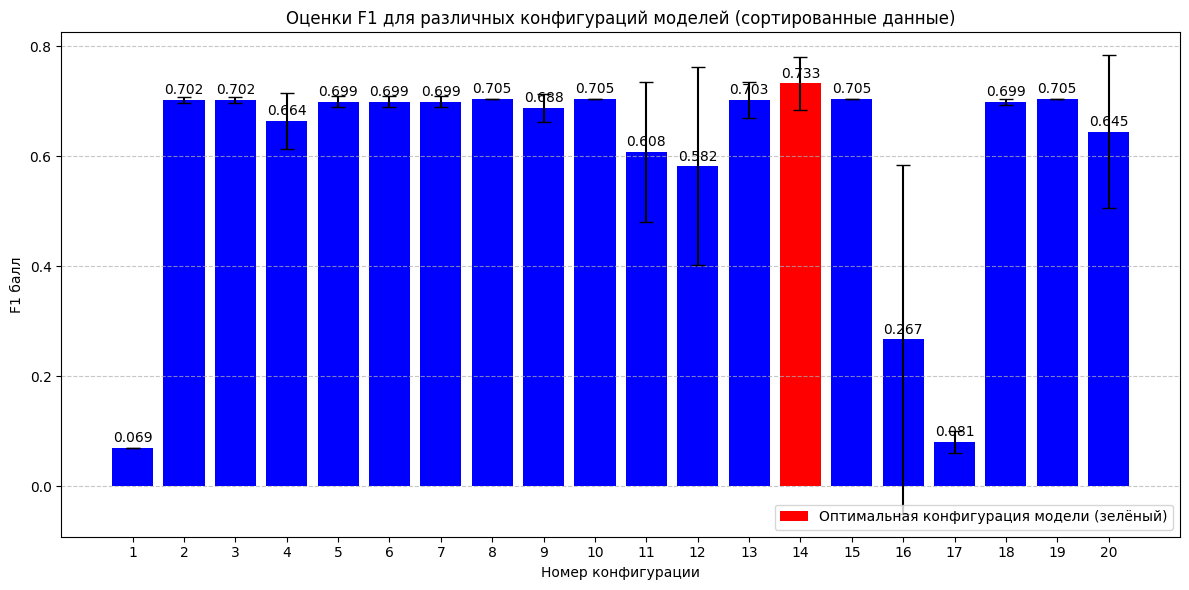

Оптимальная конфигурация модели:
Config: {'max_iter': 1000, 'hidden_layer_sizes': (64, 64, 32), 'activation': 'relu', 'solver': 'adam'}
F1 Score: 0.7325


In [30]:
# 初始化变量
best_config = None
best_score = -1
all_results = []

# 构建超参数配置列表
configs = [
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50, 30), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (100, 50, 25), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (100,), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "relu", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50,), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (50,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "relu", "solver": "adam"}
]

# 执行交叉验证，保存结果
for config in configs:
    model = MLPClassifier(random_state=42, **config)
    scores = cross_val_score(model, X, y, cv=4, scoring='f1_weighted')
    mean_score = scores.mean()
    std_score = scores.std()
    
    all_results.append((config, mean_score, std_score))
    
    print(f"Config: {config}")
    print(f"CV F1 Score: {mean_score:.4f}, Std: {std_score:.4f}\n")
    
    if mean_score > best_score:
        best_score = mean_score
        best_config = config

# 提取得分用于绘图
f1_scores = [score for (_, score, _) in all_results]
std_scores = [std for (_, _, std) in all_results]
config_labels = [f"{i+1}" for i in range(len(all_results))]

# 获取最佳配置索引
best_index = np.argmax(f1_scores)

# 默认颜色为红色，最佳配置为绿色
colors = ['blue'] * len(f1_scores)
colors[best_index] = 'red'

# 绘制柱状图
plt.figure(figsize=(12, 6))
bars = plt.bar(config_labels, f1_scores, color=colors, yerr=std_scores, capsize=5)

# 添加文本标签
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom')

# 图形说明（针对排序后的数据）
plt.title("Оценки F1 для различных конфигураций моделей (сортированные данные)")
plt.xlabel("Номер конфигурации")
plt.ylabel("F1 балл")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 图例说明：绿色为最佳配置
plt.legend(handles=[bars[best_index]], labels=['Оптимальная конфигурация модели (зелёный)'], loc='lower right')

plt.tight_layout()
plt.show()

# 打印最佳配置
print("Оптимальная конфигурация модели:")
print(f"Config: {best_config}")
print(f"F1 Score: {best_score:.4f}")


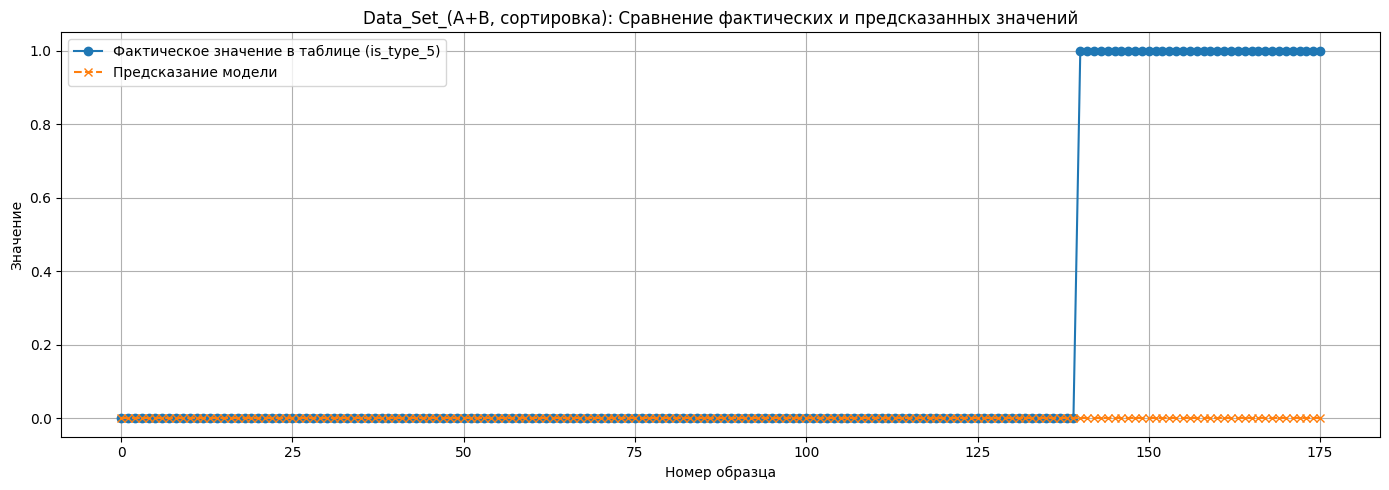

In [31]:
# 构建并训练最终模型（根据最佳配置）
final_model = MLPClassifier(hidden_layer_sizes=(64, 64, 32),
                            activation='relu',
                            solver='adam',
                            max_iter=1000,
                            random_state=42)

final_model.fit(X, y)  # 使用排序数据训练
y_pred = final_model.predict(X)  # 模型预测

N = len(y)

# 可视化对比：真实值 vs 预测值
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y[:N], label='Фактическое значение в таблице (is_type_5)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Предсказание модели', marker='x', linestyle='--')

# 图表设置
plt.title('Data_Set_(A+B, сортировка): Сравнение фактических и предсказанных значений')
plt.xlabel('Номер образца')  # Sample No.
plt.ylabel('Значение')       # value (0/1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
from sklearn.preprocessing import MinMaxScaler

# 加载原始数据（未排序版本）
raw_data = pd.read_excel("Data_Set_(A+B).xlsx")

# 计算运动特征
raw_data = compute_motion_features(raw_data)

# 构建二分类目标列：是否为类型5（Type == 5）
raw_data['target'] = (raw_data['Type'] == 5).astype(int)

# 选定用于建模的特征列
feature_columns = [
    'N1', 'N2', 'N3',
    'ω1', 'ω2', 'ω3',
    'I1', 'I2', 'I3',
    'gx', 'gy', 'gz',
    'ax', 'ay', 'az',
    'Vx', 'Vy', 'Ω',
    'Ix', 'Iy', 'Iφ', 'IΣ'
]

# 提取特征与标签
X = raw_data[feature_columns]
y = raw_data['target']

# 归一化处理（Min-Max 标准化到 [0, 1] 区间）
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


Config 1: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'relu', 'solver': 'adam'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 2: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'adam'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 3: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 4: {'max_iter': 500, 'hidden_layer_sizes': (50, 30), 'activation': 'tanh', 'solver': 'adam'}
Mean F1 Score: 0.7048, Std: 0.0000



e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config 5: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'adam'}
Mean F1 Score: 0.8045, Std: 0.0700

Config 6: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 7: {'max_iter': 1000, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 8: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'logistic', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000



e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config 9: {'max_iter': 500, 'hidden_layer_sizes': (100, 50, 25), 'activation': 'tanh', 'solver': 'adam'}
Mean F1 Score: 0.8445, Std: 0.0847

Config 10: {'max_iter': 500, 'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam'}
Mean F1 Score: 0.7048, Std: 0.0000



e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config 11: {'max_iter': 500, 'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'solver': 'adam'}
Mean F1 Score: 0.8621, Std: 0.0606

Config 12: {'max_iter': 1000, 'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 13: {'max_iter': 1000, 'hidden_layer_sizes': (64, 64, 32), 'activation': 'tanh', 'solver': 'adam'}
Mean F1 Score: 0.8190, Std: 0.1141

Config 14: {'max_iter': 1000, 'hidden_layer_sizes': (64, 64, 32), 'activation': 'relu', 'solver': 'adam'}
Mean F1 Score: 0.8767, Std: 0.0549

Config 15: {'max_iter': 500, 'hidden_layer_sizes': (32, 32), 'activation': 'logistic', 'solver': 'adam'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 16: {'max_iter': 500, 'hidden_layer_sizes': (32, 32), 'activation': 'relu', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000



e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\TPU_Work\yi_dong_ji_qi_ren\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Config 17: {'max_iter': 500, 'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 18: {'max_iter': 1000, 'hidden_layer_sizes': (50,), 'activation': 'tanh', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 19: {'max_iter': 1000, 'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'solver': 'sgd'}
Mean F1 Score: 0.7048, Std: 0.0000

Config 20: {'max_iter': 1000, 'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam'}
Mean F1 Score: 0.8695, Std: 0.0562



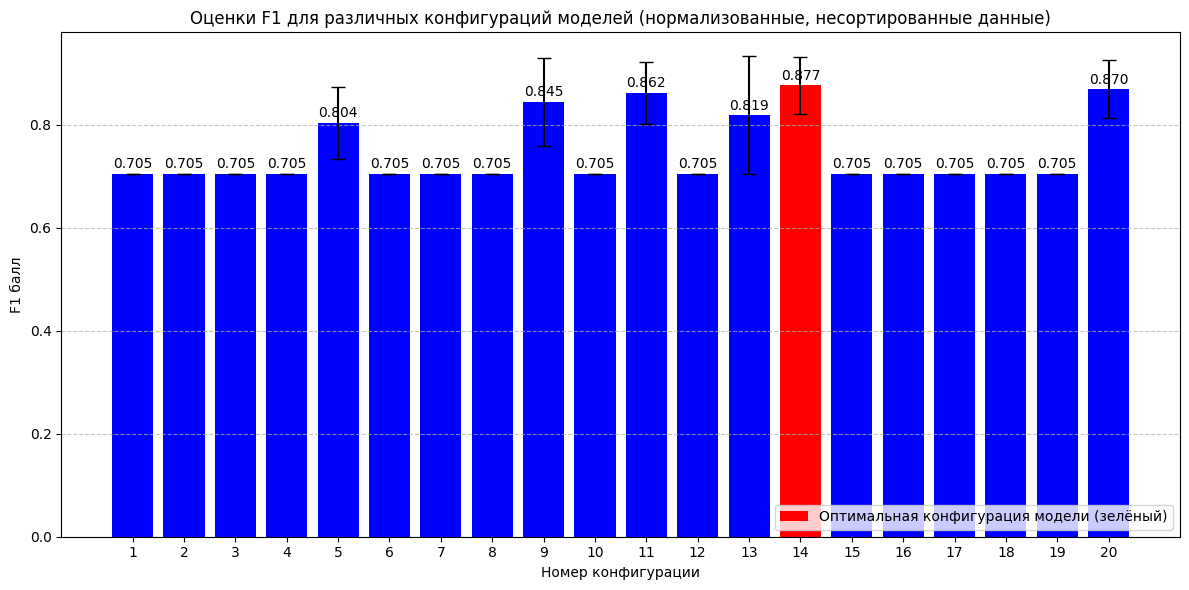

Наилучшая конфигурация модели:
Config: {'max_iter': 1000, 'hidden_layer_sizes': (64, 64, 32), 'activation': 'relu', 'solver': 'adam'}
F1 Score: 0.8767


In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

# 模型参数候选集合
parameter_grid = [
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50, 30), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (100, 50, 25), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (100,), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "relu", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50,), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (50,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "relu", "solver": "adam"}
]

# 存储每次结果
results = []
best_result = {"score": -1, "index": -1, "config": None}

# 遍历参数组合并评估
for idx, params in enumerate(parameter_grid):
    clf = MLPClassifier(random_state=42, **params)
    cv_scores = cross_val_score(clf, X_scaled, y, cv=4, scoring='f1_weighted')
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()

    results.append((params, mean_cv, std_cv))

    print(f"Config {idx+1}: {params}")
    print(f"Mean F1 Score: {mean_cv:.4f}, Std: {std_cv:.4f}\n")

    if mean_cv > best_result["score"]:
        best_result.update({"score": mean_cv, "index": idx, "config": params})

# 准备绘图数据
f1_scores = [r[1] for r in results]
std_scores = [r[2] for r in results]
labels = [str(i+1) for i in range(len(results))]

# 设置颜色：红色为默认，最佳配置为绿色
bar_colors = ['blue'] * len(results)
bar_colors[best_result["index"]] = 'red'

# 绘图
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, f1_scores, yerr=std_scores, color=bar_colors, capsize=5)

# 添加标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.3f}", ha='center', va='bottom')

# 图形配置
plt.title("Оценки F1 для различных конфигураций моделей (нормализованные, несортированные данные)")
plt.xlabel("Номер конфигурации")
plt.ylabel("F1 балл")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# 图例（绿色为最优配置）
plt.legend(handles=[bars[best_result["index"]]], labels=["Оптимальная конфигурация модели (зелёный)"], loc='lower right')

plt.tight_layout()
plt.show()

# 打印最优配置
print("Наилучшая конфигурация модели:")
print(f"Config: {best_result['config']}")
print(f"F1 Score: {best_result['score']:.4f}")


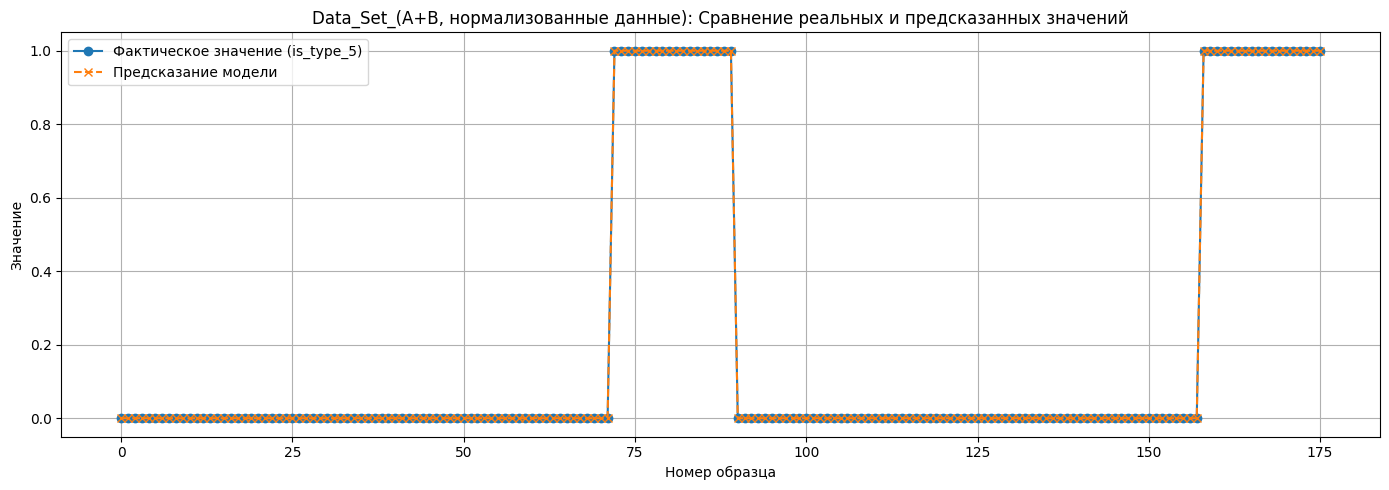

In [35]:
# 构建并训练最终模型（使用最佳结构）
final_model = MLPClassifier(hidden_layer_sizes=(64, 64, 32),
                            activation='relu',
                            solver='adam',
                            max_iter=1000,
                            random_state=42)

# 模型训练
final_model.fit(X_scaled, y)

# 模型预测
y_pred = final_model.predict(X_scaled)

# 样本数量（如需限制图像长度，可改为 N = min(100, len(y))）
N = len(y)

# 可视化预测结果对比
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y[:N], label='Фактическое значение (is_type_5)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Предсказание модели', marker='x', linestyle='--')

# 图表配置
plt.title('Data_Set_(A+B, нормализованные данные): Сравнение реальных и предсказанных значений')
plt.xlabel('Номер образца')  # Sample No.
plt.ylabel('Значение')       # value (0/1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [36]:
from sklearn.preprocessing import MinMaxScaler

# 导入已排序数据集
sorted_data = pd.read_excel("Data Set_(A+B) (sort).xlsx")

# 计算派生运动特征（基于 ω 和 I）
sorted_data = compute_motion_features(sorted_data)

# 构建目标列（是否为类型5）
sorted_data['target'] = (sorted_data['Type'] == 5).astype(int)

# 定义特征列列表
selected_features = [
    'N1', 'N2', 'N3',
    'ω1', 'ω2', 'ω3',
    'I1', 'I2', 'I3',
    'gx', 'gy', 'gz',
    'ax', 'ay', 'az',
    'Vx', 'Vy', 'Ω',
    'Ix', 'Iy', 'Iφ', 'IΣ'
]

# 提取特征矩阵和标签
X = sorted_data[selected_features]
y = sorted_data['target']

# 执行 Min-Max 归一化（标准化到 0～1）
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


Config 1: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'relu', 'solver': 'adam'}
F1 Score: 0.0695, Std: 0.0000

Config 2: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'adam'}
F1 Score: 0.7020, Std: 0.0049

Config 3: {'max_iter': 500, 'hidden_layer_sizes': (20,), 'activation': 'tanh', 'solver': 'sgd'}
F1 Score: 0.7020, Std: 0.0049

Config 4: {'max_iter': 500, 'hidden_layer_sizes': (50, 30), 'activation': 'tanh', 'solver': 'adam'}
F1 Score: 0.6641, Std: 0.0513

Config 5: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'adam'}
F1 Score: 0.6991, Std: 0.0100

Config 6: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
F1 Score: 0.6991, Std: 0.0100

Config 7: {'max_iter': 1000, 'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'solver': 'sgd'}
F1 Score: 0.6991, Std: 0.0100

Config 8: {'max_iter': 500, 'hidden_layer_sizes': (64, 32), 'activation': 'logistic', 'solver'

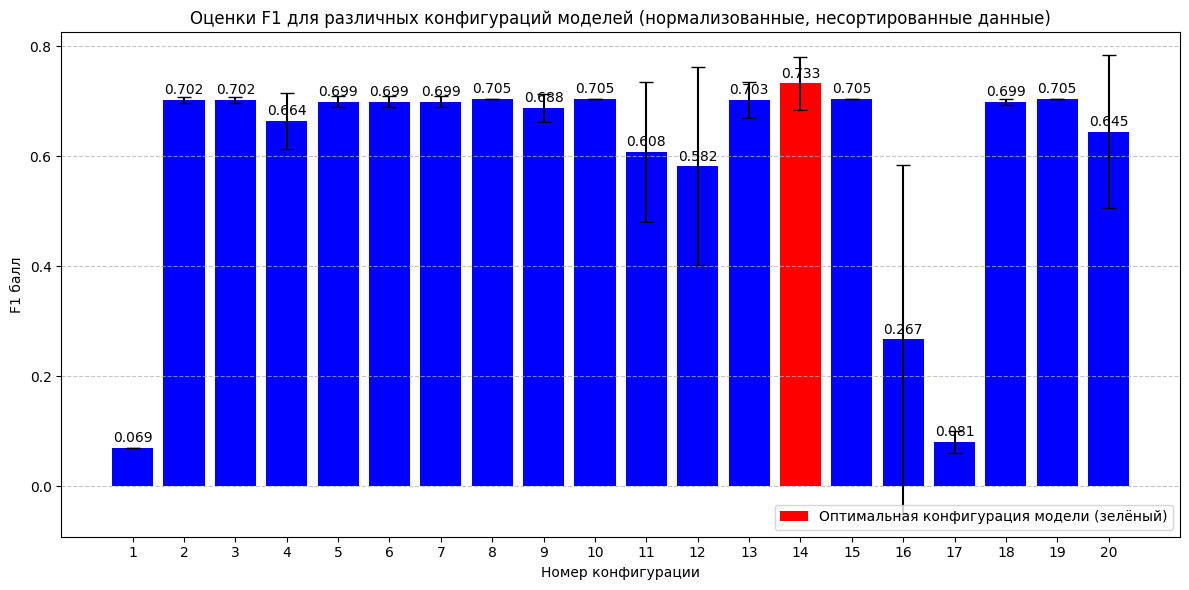

Оптимальная конфигурация модели:
Config: {'max_iter': 1000, 'hidden_layer_sizes': (64, 64, 32), 'activation': 'relu', 'solver': 'adam'}
F1 Score: 0.7325


In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 初始化变量用于记录最优模型配置和得分
optimal_config = None
highest_f1 = -1
results = []

# 定义超参数搜索空间（保持一致）
param_grid = [
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (20,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50, 30), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 32), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (64, 32), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (100, 50, 25), "activation": "tanh", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (100,), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (128, 64), "activation": "relu", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "tanh", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (64, 64, 32), "activation": "relu", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "logistic", "solver": "adam"},
    {"max_iter": 500,"hidden_layer_sizes": (32, 32), "activation": "relu", "solver": "sgd"},
    {"max_iter": 500,"hidden_layer_sizes": (50,), "activation": "relu", "solver": "adam"},
    {"max_iter": 1000,"hidden_layer_sizes": (50,), "activation": "tanh", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "logistic", "solver": "sgd"},
    {"max_iter": 1000,"hidden_layer_sizes": (100, 50), "activation": "relu", "solver": "adam"}
]

# 遍历所有配置并评估 F1 分数
for idx, params in enumerate(param_grid):
    clf = MLPClassifier(random_state=42, **params)
    f1_scores = cross_val_score(clf, X, y, cv=4, scoring='f1_weighted')
    mean_f1 = f1_scores.mean()
    std_f1 = f1_scores.std()

    results.append((params, mean_f1, std_f1))

    print(f"Config {idx + 1}: {params}")
    print(f"F1 Score: {mean_f1:.4f}, Std: {std_f1:.4f}\n")

    if mean_f1 > highest_f1:
        highest_f1 = mean_f1
        optimal_config = params
        best_index = idx

# 提取绘图所需数据
mean_scores = [r[1] for r in results]
std_devs = [r[2] for r in results]
labels = [str(i + 1) for i in range(len(results))]

# 设置颜色：默认红色，最优绿色
bar_colors = ['blue'] * len(results)
bar_colors[best_index] = 'red'

# 绘制柱状图
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, mean_scores, yerr=std_devs, color=bar_colors, capsize=5)

# 添加分数标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3f}", ha='center', va='bottom')

# 图表设置
plt.title("Оценки F1 для различных конфигураций моделей (нормализованные, несортированные данные)")
plt.xlabel("Номер конфигурации")
plt.ylabel("F1 балл")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 图例说明：绿色为最佳配置
plt.legend(handles=[bars[best_index]], labels=["Оптимальная конфигурация модели (зелёный)"], loc='lower right')

plt.tight_layout()
plt.show()

# 输出最佳配置信息
print("Оптимальная конфигурация модели:")
print(f"Config: {optimal_config}")
print(f"F1 Score: {highest_f1:.4f}")


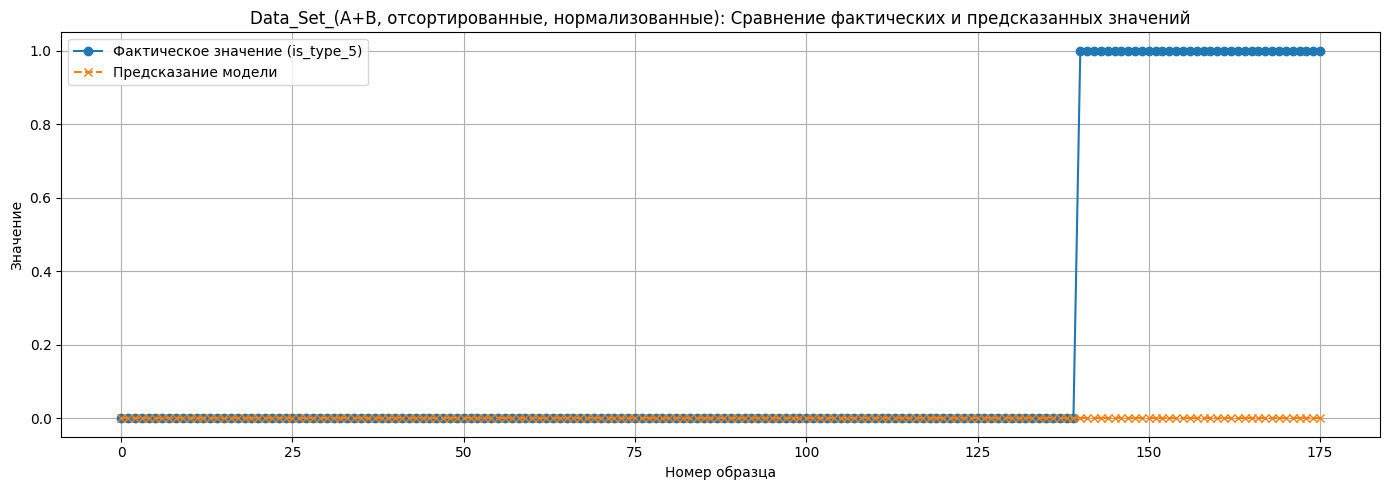

In [38]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

# 构建并训练最终模型（使用最佳结构）
final_model = MLPClassifier(hidden_layer_sizes=(64, 64, 32),
                            activation='relu',
                            solver='adam',
                            max_iter=1000,
                            random_state=42)

# 模型拟合
final_model.fit(X, y)

# 模型预测
y_pred = final_model.predict(X)

# 可视化样本数量（如需限制前100个，请设为 N = 100）
N = len(y)  # 或 N = min(100, len(y))

# 绘图：真实值 vs 模型预测值
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y[:N], label='Фактическое значение (is_type_5)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Предсказание модели', marker='x', linestyle='--')

# 图表样式设置
plt.title("Data_Set_(A+B, отсортированные, нормализованные): Сравнение фактических и предсказанных значений")
plt.xlabel("Номер образца")   # Sample number
plt.ylabel("Значение")        # 0 or 1
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
import pandas as pd

# ----------------------------------------
# 1. 加载原始数据并计算运动特征
# ----------------------------------------

# 加载未排序原始数据
raw_data = pd.read_excel("Data_Set_(A+B).xlsx")

# 计算自定义运动特征（compute_motion_features 函数已定义）
raw_data = compute_motion_features(raw_data)

# 构建目标列（是否为表面类型5）
raw_data['target'] = (raw_data['Type'] == 5).astype(int)

# 选取特征列
selected_features = [
    'N1', 'N2', 'N3',
    'ω1', 'ω2', 'ω3',
    'I1', 'I2', 'I3',
    'gx', 'gy', 'gz',
    'ax', 'ay', 'az',
    'Vx', 'Vy', 'Ω',
    'Ix', 'Iy', 'Iφ', 'IΣ'
]

# 提取特征矩阵和目标变量
X = raw_data[selected_features]
y = raw_data['target']

# ----------------------------------------
# 2. 归一化特征处理（Min-Max）
# ----------------------------------------

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------------------
# 3. 样本不平衡处理（SMOTE 与 ADASYN）
# ----------------------------------------

# 使用 SMOTE 增强少数类样本
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# 使用 ADASYN 增强少数类样本
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_scaled, y)


In [40]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

# ----------------------------------------
# 使用 SMOTE 数据训练与评估
# ----------------------------------------

# 构建模型（保持结构不变）
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 64, 32),
                          activation='relu',
                          solver='adam',
                          max_iter=1000,
                          random_state=42)

# 模型训练
mlp_model.fit(X_smote, y_smote)

# 模型预测
y_pred_smote = mlp_model.predict(X_smote)

# 性能评估
print(" SMOTE 结果评估")
print("Accuracy:", accuracy_score(y_smote, y_pred_smote))
print("F1 Score:", f1_score(y_smote, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_smote, y_pred_smote))
print("Classification Report:\n", classification_report(y_smote, y_pred_smote))


# ----------------------------------------
# 使用 ADASYN 数据训练与评估
# ----------------------------------------

# 重新拟合同一模型（或新建模型对象）
mlp_model.fit(X_adasyn, y_adasyn)
y_pred_adasyn = mlp_model.predict(X_adasyn)

print("\n ADASYN 结果评估")
print("Accuracy:", accuracy_score(y_adasyn, y_pred_adasyn))
print("F1 Score:", f1_score(y_adasyn, y_pred_adasyn))
print("Confusion Matrix:\n", confusion_matrix(y_adasyn, y_pred_adasyn))
print("Classification Report:\n", classification_report(y_adasyn, y_pred_adasyn))


 SMOTE 结果评估
Accuracy: 0.9928571428571429
F1 Score: 0.9929078014184397
Confusion Matrix:
 [[138   2]
 [  0 140]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       140
           1       0.99      1.00      0.99       140

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280


 ADASYN 结果评估
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[140   0]
 [  0 139]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       139

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



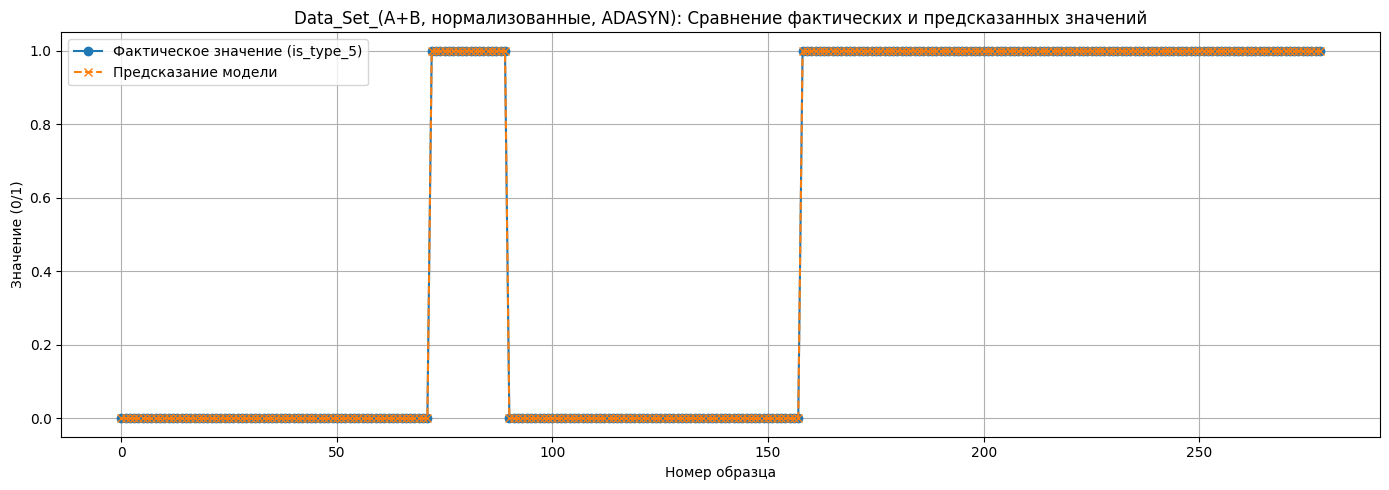

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# 可视化样本数量（如需限制前100个样本，替换为 N = 100）
N = len(y_adasyn)  # 使用 ADASYN 重采样后的样本数量

# 绘制预测结果对比图
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y_adasyn[:N], label='Фактическое значение (is_type_5)', marker='o')
plt.plot(np.arange(N), y_pred_adasyn[:N], label='Предсказание модели', marker='x', linestyle='--')

# 图表样式与说明
plt.title("Data_Set_(A+B, нормализованные, ADASYN): Сравнение фактических и предсказанных значений")
plt.xlabel("Номер образца")   # Sample number
plt.ylabel("Значение (0/1)")  # Binary label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ----------------------------------------
# 加载并处理外部验证集（Data_Set_C）
# ----------------------------------------

# 加载数据集 C
data_c = pd.read_excel("Data_Set_C.xlsx")
data_c = compute_motion_features(data_c)

# 创建二分类目标列
data_c['target'] = (data_c['Type'] == 5).astype(int)

# 提取特征与标签
X_c = data_c[features]
y_c = data_c['target']

# 使用原训练数据的归一化器进行标准化（不重新fit）
X_c_scaled = scaler.transform(X_c)

# ----------------------------------------
# 使用已训练模型进行预测
# ----------------------------------------

y_c_pred = mlp_model.predict(X_c_scaled)


# ----------------------------------------
# 输出评估指标
# ----------------------------------------

print(" 外部数据集 Data_Set_C 评估结果")
print("Accuracy:", accuracy_score(y_c, y_c_pred))
print("F1 Score:", f1_score(y_c, y_c_pred))
print("Confusion Matrix:\n", confusion_matrix(y_c, y_c_pred))
print("Classification Report:\n", classification_report(y_c, y_c_pred))


 外部数据集 Data_Set_C 评估结果
Accuracy: 0.9482758620689655
F1 Score: 0.8695652173913043
Confusion Matrix:
 [[45  1]
 [ 2 10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        46
           1       0.91      0.83      0.87        12

    accuracy                           0.95        58
   macro avg       0.93      0.91      0.92        58
weighted avg       0.95      0.95      0.95        58



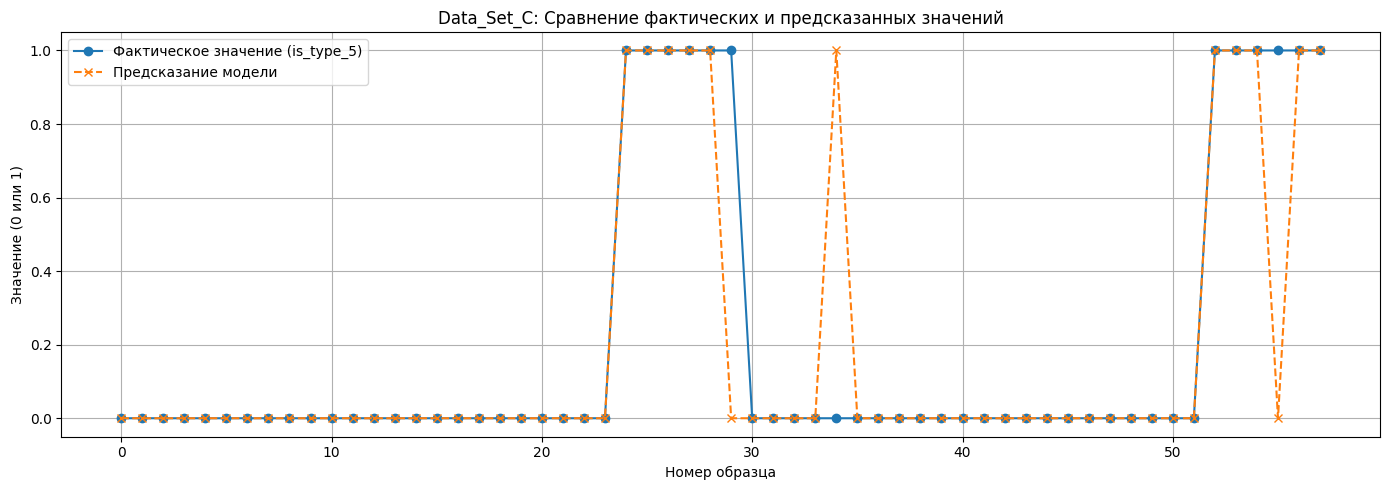

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 获取样本数量（可限制为前 N 项，如需 N = 100）
sample_count = len(y_c)

# 构造索引序列
indices = np.arange(sample_count)

# 创建图形窗口
plt.figure(figsize=(14, 5))

# 绘制真实标签
plt.plot(indices, y_c[:sample_count], label='Фактическое значение (is_type_5)', marker='o')

# 绘制预测值
plt.plot(indices, y_c_pred[:sample_count], label='Предсказание модели', marker='x', linestyle='--')

# 图表标题与标签设置
plt.title("Data_Set_C: Сравнение фактических и предсказанных значений")
plt.xlabel("Номер образца")       # Sample No.
plt.ylabel("Значение (0 или 1)")  # value
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
